In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Metropolis-Hasting algorithm

In [3]:

def Delta_H(r,delta,u,x,N):
    """""
    Calculates the difference of the final and initial hamiltonian without needing to actually calculate the hamiltonian

    Arguments: the list u, the site that was changed x, the length of the list N, r the random variable between -1 and 1
               and delta a fixed scale parameter
               
    """""
    L=64
    alpha=L/N
    return (1/alpha)*(2*r*delta*(2*u[x] + r*delta - u[(x-1)] - u[(x+1)]))


In [4]:
def exp_m_exact(N): #exact expectation value of the magnetisation 
    return 0
    
def exp_m_2_exact(N,beta):#exact expectation value of the magnetisation  squared
    L=64
    alpha=L/N
    return (N-1)*(alpha/(2*beta*(N**2)))   #add something that depends on the sum

def exp_m(u,N):  #analytical calculation of the magnetisation 
    N=len(u)
    sum_u=0

    # Dririchlet boundary condiions
    u[0]=0
    u[-1]=0

    for i in range(N-1):
        sum_u+=u[i]

    return (1/N)*sum_u 

def exp_m_2(u,N):  #analytical calculation of the magnetisation squared
    N=len(u)
    sum_u=0

    # Dririchlet boundary condiions
    u[0]=0
    u[-1]=0

    for i in range(N-1):
        sum_u+=u[i]**2
    return ((1/N)**2)*sum_u

def exp_H(u,N):   #analytical calculation of the Hamiltonian -> energy
    N=len(u)
    L=64
    alpha=L/N
    # Dririchlet boundary condiions
    u[0]=0
    u[-1]=0

    sum_u=0
    for i in range(1,N-1):
        sum_u+=(u[i]-u[i-1])**2

    return (1/alpha)*sum_u


In [5]:
def Metropolis_Hasting_sweep(u,delta=2,N=64,beta=1):
    """
    Make sweeps on random site of the u list with a fixed scale parameter

    Arguments: the list u(independently if it is fine or coarsed), delta scale parameter, length N (not necessary as later is
               defined as len(u)), inverse temperature beta
    """
    N=len(u)    #redife N as the length of u
 
    u_new=u.copy()  # make a new list in order to manipulate u but also keep the initial form 
    prob=[]         # probability of acceptance

    for i in range(N-1):
        x=np.random.randint(1,N-1)      # choose random site 
        #x=i
        r=np.random.uniform(-1,1)       # r~U([-1,1])

        u_prime=u_new[x]+(r*delta)      
        #Metropolis-Hasting accept/reject
        if np.random.uniform()<=np.exp(-Delta_H(r,delta,u_new,x,N)):
            u_new[x]=u_prime
            prob.append(1)     
        else:            
            u_new[x]=u_new[x]
            prob.append(0)
            
    return u_new
    

### Test the algorithm with the parameters from the sheet

In [6]:
N=64
u=[np.random.uniform(5,6) for i in range(N)]   #initialize u between 0 and 1. The initial conditions shouldn't 
                                               #matter that much, as we have a thermalization to the correct values
mean_m=[]       #mean magnetization taken from the analytic formula
mean_m_2=[]     #mean magnetization squared taken from the analytic formula
energy=[]       #mean energy taken from the analytic formula    

mean_mag_exact=[]      #lists to stor the exact values
mean_mag_2_exact=[]

nTherm=2000

for i in range(nTherm):
    u_sweep=Metropolis_Hasting_sweep(u)   #make sweep 
    u=u_sweep

for i in range(5000):
    u_sweep=Metropolis_Hasting_sweep(u)   #make sweep 
    u=u_sweep
     
    mean_m.append(exp_m(u_sweep,N))                #Save the mean of the observables measured
    mean_m_2.append(exp_m_2(u_sweep,N))
    energy.append(exp_H(u_sweep,N))
   
    
    mean_mag_exact.append(exp_m_exact(N))                   #save the exact values
    mean_mag_2_exact.append(exp_m_2_exact(N,beta=1))

    


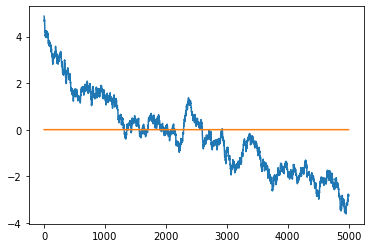

In [7]:
plt.plot(mean_m)
plt.plot(mean_mag_exact)       # Briefly plotting the exact values and the analytical results

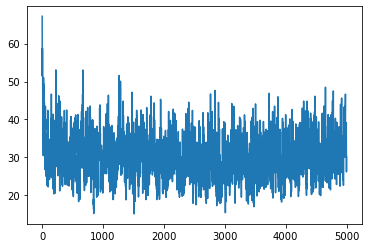

In [8]:

plt.plot(energy)

In [9]:
#Fine to coarse
def FtC(u):
    u_C=[u[i] for i in range(0,len(u),2)]
    return u_C

#Coarse to Fine
def CtF(u):
    u_F=[]
    for i in range(2*len(u)):
        if i%2==0:
            u_F.append(u[i//2])
        else:
            u_F.append((u[((i-1)//2)-1]+u[((i+1)//2)-1])/2)
    return u_F

In [10]:
def phi_2a(u,u_2a,phi_a,N=64):
    """ 
    Calculate φ(2α) as a function of φ(α)
    Arguments: fine list u , coarsed list u_2a, external field of previous layer phi_a
    """
    N=len(u)
    L=64
    alpha=L/N
    s=u.copy()
    phi_2a_r=[]
    for i in range(len(u_2a)-1):
        phi_2a_r.append((1/(2*(alpha)**2))*(-s[2*i-2]+2*s[2*i]-s[2*i+2])+(1/4)*(phi_a[2*i-1]+phi_a[2*i]+phi_a[2*i+1]))

    return phi_2a_r


In [11]:
def Hamiltonian_F(u,phi,N):
    """ 
    Calculate the Hamiltonian with the dependence on the external field phi

    Arguments:list u, external field phi, and N(unesessary redifined later as len(u))
    """
    N=len(u)
    L=64
    alpha=L/N

    sum_u=0

    #Dirichlet boundary condition
    u[0]=0
    u[N-1]=0

    for i in range(N):
        sum_u+=(u[i]-u[i-1])**2

    sum_phi=0
    for i in range(N-1):
        sum_phi+=u[i]*phi[i]

    return (1/alpha)*(sum_u)

In [79]:
def gamma_cycle(u,depth,vpre):
    """ 
    Function that take a configuration and do a recursion step

    Arguments: configuration list u, willing depth of the recursion step, number of sweeps per step vpre
    """
    d=depth #arbitraly chosen
    #u=np.zeros(len(u)) is what is suggested

    for i in range(vpre):               #sweep vpre times
        u_r=Metropolis_Hasting_sweep(u)
        u=u_r
        
    u_r_copied=u_r.copy()           #copy the initial coniguration to be able to save it

    for i in range(d):
        u_r_C=FtC(u_r_copied)           #coarse and
        for i in range(vpre):           #sweep vpre times
            u_r_C=Metropolis_Hasting_sweep(u_r_C)
        u_r_copied=u_r_C

    for i in range(d):
        u_r_F=CtF(u_r_C)                #uncoarse and
        for i in range(vpre):           #sweep vpre times
            u_r_F=Metropolis_Hasting_sweep(u_r_F)
        u_r_C=u_r_F

    for i in range(vpre):                   #sweep vpost=vpre times
        u_r=Metropolis_Hasting_sweep(u_r_F)
        u_r_F=u_r
    
    
    if len(u_r)!=len(u): print("Did't work properly")  #Test

    return u_r
    

In [80]:
def MG_simulation(u,cycle,vpre):
    """ 
    Implimenting the Multi-grid algorithm as mentioned in the sheet

    Arguments:configuration list u, type of the cycle in the variable cycle, number of pre and post coarsening MH sweep vpre
    """
    #Define if cycle V or W
    if cycle=="V":
        gamma=1
    elif cycle=="W":
        gamma=2

    #pre-coarsing MH sweeps
    for i in range(vpre):
        u_pre=Metropolis_Hasting_sweep(u)
        u=u_pre
    
    phi_a=[0 for i in range(len(u_pre))] #define phi_a of the fine level

    u_F=u_pre.copy()
    u_coarse=FtC(u_F)       # First coarsening! Fine -> Level 2a

    #we calculate phi_2a and the Hamiltonian for the coarsed level
    phi2a=phi_2a(u_F,u_coarse,phi_a,N=len(u_F))
    Ham_Coarse=Hamiltonian_F(u_coarse,phi2a,N=len(u_coarse))

    for i in range(gamma):      #recursion. Gamma cycles
        u_gamma=gamma_cycle(u_coarse,3,vpre)
        u_coarse=u_gamma
       
    u_post=CtF(u_gamma)     #Last uncoarsening! Level 2a -> Fine 
    for i in range(vpre):
        u_post=Metropolis_Hasting_sweep(u_post)

    if len(u_pre)!= len(u_post): print("Didn't work properly")  # Test 

    return u_post


### We use again the functions created on the previous sheet for the autocorrelation and $C(\tau)$ factor

In [14]:
def estimator_gamma_tau(m,tau):     #We calculate the Gamma estimator from the sheet
    m_bar=sum(m)/len(m)             #we calculate the mean of the list
    sum_of_ms=0                     #for the sum of the magnetisation
    num_of_pairs=0                  #for the #(k,l)
    
    #sum over the correlated sites of the list as indicated in the sheet
    for i in range(len(m)-tau):           
        sum_of_ms+=(m[i]-m_bar)*(m[i+tau]-m_bar)
        num_of_pairs+=1

    return (1/num_of_pairs)*sum_of_ms    # return the formula given in the sheet

def estimator_C_tau(m,tau):
    return estimator_gamma_tau(m,tau)/estimator_gamma_tau(m,tau=0)   #C(τ)=Γ(τ)/Γ(0)

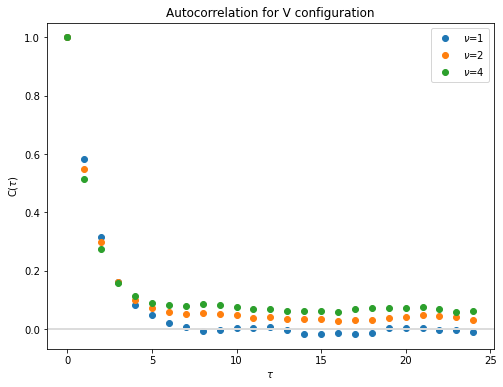

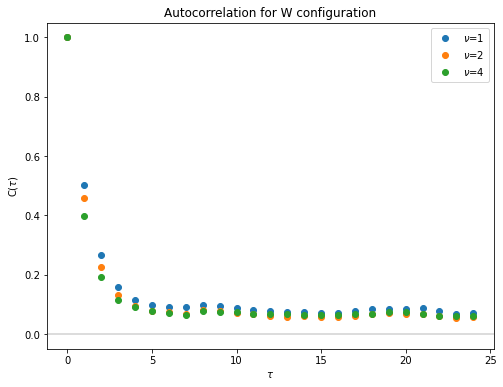

In [82]:
#Initialize u
u_in=[np.random.uniform(5,6) for i in range(64)]

mean_mag_2_MG=[] # create a list to save the squared magnetization

for cycle in ["V","W"]:      # go through the 2 type of cycles
    u=u_in.copy()            # with the same configuation as initial configuration
    plt.figure(figsize=(8,6))
    for nu_pre in [1,2,4]: #go through the different values of nu
        # make multiple measurements
        for i in range(10000):
            mean_mag_2_MG.append(exp_m_2(u,len(u)))  #measure the magnetization pre and post 
            u_post=MG_simulation(u,cycle,nu_pre)
            u=u_post

        C_tau=[]
        for t in range(25):
            C_tau.append(estimator_C_tau(mean_mag_2_MG,t))  # Calculate the autocorrelation of the squared magnetisation

        # and plot it
        plt.plot(C_tau,"o",label=r"$\nu$={}".format(nu_pre))
        plt.axhline(0,color="gainsboro")
        plt.ylabel(r"C($\tau$)")
        plt.xlabel(r"$\tau$")
        plt.title(r"Autocorrelation for {} configuration".format(cycle))
        plt.legend()